# We developed this in VS Code, copied the code here

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import time

# Get data

In [3]:
import keras

# Referece: Aayush Agrawal. 2020
# Building Neural Network from scratch | by Aayush Agrawal | Towards Data Science.
# [ONLINE] Available at: https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9
# [Accessed 15 December 2020]

# get data as in the refference above, under the "Full network" section
def load_dataset():
    
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

    # Normalizes the data from the [0-255] range to the decimal [0-1] range
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    # Reserves the last 10000 training examples as the validation data
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    X_train = X_train.reshape([X_train.shape[0], -1])
    X_val = X_val.reshape([X_val.shape[0], -1])
    X_test = X_test.reshape([X_test.shape[0], -1])
        
    return X_train, y_train, X_val, y_val, X_test, y_test

Using TensorFlow backend.


In [4]:
class Relu():
    def __init__(self):
        pass

    # formula can be found in lecture
    def relu(self, x):
        output = np.maximum(0.0, x)
        return output

    # apply relu to numpy.array
    def forward(self, zs):
        output = self.relu(zs)
        return output
    
    # Reference: Github - Yusuke Sugomori Repositories. 2020
    # Title: Dropout Neural Networks (with ReLU).
    # [ONLINE] Available at: https://gist.github.com/yusugomori/cf7bce19b8e16d57488a.
    # [Accessed 15 December 2020].
    # copied line 24 - relu_derivated = zs > 0
    def backward(self, zs, next_layer_sigma_z):
        # Calculates derivative of next_layer_sigma_z (error) with respect to zs
        relu_derivated = zs > 0
        # chain rule
        output = next_layer_sigma_z * relu_derivated

        return output

In [5]:
class Sigmoid():
    def __init__(self):
        pass

    # formula for sigmoid, can be found in lectures
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    # apply sigmoid to a numpy.array
    def forward(self, zs):
        output = self.sigmoid(zs)
        return output
    
    # derivative of sigmoid, used for calculating cost
    # derivative of the cost/error with respect to sigmoid is: cost * sigmoid derivated
    # chain rule
    # formula can be found in the lectures
    def backward(self, zs, next_layer_sigma_z):
        sigmoid_derivated = self.sigmoid(zs) * (1 - self.sigmoid(zs))
        output = next_layer_sigma_z * sigmoid_derivated
        return output

In [6]:
class Dense():

    def __init__(self, neurons_in_input, neurons_in_output, l_r=0.05):

        self.neurons_in_input = neurons_in_input
        self.neurons_in_output = neurons_in_input

        self.l_r = l_r

        # docs.scipy. 2016.
        # numpy.random.normal. 
        # [ONLINE] Available at: https://docs.scipy.org/doc//numpy-1.10.4/reference/generated/numpy.random.normal.html. 
        # [Accessed 15 December 2020].

        # we used the above website to change the SCALE ATTRIBUTE from 1.0 to 0.1 for the np.random.normal function
        # -> we got the below error when scale = 1
        # error in Cross Entropy class
        # RuntimeWarning: overflow encountered in exp
        # e = np.exp(predictions)
        # END OF ERROR
        # fixed error with scale = 0.1, because now the numbers are smaller and there is no overflow in RELU + RELU layers, 
        # at the softmax function in the gradient of the loss
        self.weights = np.random.normal(scale=0.1,
                                        size=(neurons_in_input, neurons_in_output))
        self.biases = np.random.normal(size=(neurons_in_output))

    # Returns activations for dense layer
    def forward(self, activations):

        # this is (weights * activations) + bias
        # formula in lecture and lab 7
        return np.dot(activations, self.weights) + self.biases

    # returns the sigma_z for dense layer
    # also updates the weights and biases using the gradients for weights and biases and LEARNING RATE
    # a similar formula was used in lecture and lab 7
    def backward(self, activation, next_layer_sigma_z):

        # sigma_z for this layer
        # formula in lecture and lab 7
        # for each image, cost at each neuron
        # derivative of loss/cost (next_layer_sigma_z) with respect to activation is next_layer_sigma_z * weights
        # because (w1a1 + w2a2 + ... + wnan) + b derivated with respect to activations (a1, a2, ..., an) is just the weights
        # you transpose the weights because you need the shape of the next_layer_sigma_z
        # for example, if weights is shape (200,100) and next_layer_sigma_z is shape (minibatch_size, 100)
        # you need your new sigma_z to be of shape (minibatch_size, 200), so you can use it in the next iteration of backward pass
        sigma_z = np.dot(next_layer_sigma_z, self.weights.transpose())

        # gradient of the weights of this layer
        # formula in lecture and lab 7
        # derivative of loss/cost (next_layer_sigma_z) with respect to weights is next_layer_sigma_z * activations
        # must be of shape (200, 100) (same as weights, so we can update)
        # lets say activation is of shape (minibatch_size, 200) (for each image, 200 neurons)
        # and next_layer_sigma_z (next layer error) is (minibatch_size, 100) (for each image, 100 neurons)
        # we transpose activation in (200, minibatch size)
        # we can use dot for shapes (200, minibatch size) , (minibatch size, 100)
        # and we get shape for gradient of weights (200,100)
        gradient_w = np.dot(activation.transpose(), next_layer_sigma_z)

        # gradient of the biases of his layer
        # formula in lecture and lab 7
        # derivative of loss/cost (next_layer_sigma_z) with respect to biases is next_layer_sigma_z
        # since bias is of shape (100), gradient must be of shape (100)
        # shape of next_layer_sigma_z is (32, 100) for each image, 100 neurons
        # so we need to average next_layer_sigma_z so that the gradient for the bias is shape (100)
        gradient_b = np.zeros(shape=(len(next_layer_sigma_z[0])))

        # add up all gradients for each image in minibatch
        for single_image_sigma_z in next_layer_sigma_z:
            gradient_b += single_image_sigma_z

        # divide by the length of the minibatch
        gradient_b = gradient_b / len(next_layer_sigma_z[0])

        # update weights and biases with gradient
        # formula in lecture and lab 7
        self.weights -= self.l_r * gradient_w
        self.biases -= self.l_r * gradient_b

        # return the gradient (error) in this layer
        return sigma_z

In [9]:
# Referece: 1
# Aayush Agrawal. 2020
# Building Neural Network from scratch | by Aayush Agrawal | Towards Data Science.
# [ONLINE] Available at: https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9
# [Accessed 15 December 2020]

# Referece: 2
# Raul Gomez Bruballa. 2018
# Understanding Categorical Cross-Entropy Loss, Binary Cross-Entropy Loss, Softmax Loss, Logistic Loss, Focal Loss and all those confusing names.
# [ONLINE] Available at: https://gombru.github.io/2018/05/23/cross_entropy_loss/.
# [Accessed 15 December 2020].

class CrossEntropy():

    def __init__(self):
        # never used
        # we are using a custom_softmax, that is referenced below
        # self.softmax = Softmax()
        pass

    # Reference 2 - formula from images and text
    # scroll down to Categorical Cross-Entropy loss ( Negative Likelihood Loss )
    # we built this function with the help of the first 2 images and the text associated with them
    def softmax_cross_entropy_loss(self, zs, targets):

        # building the predictions list
        # a list of what was predicted
        # get targets and zs
        # target is an int
        # zs are an array of shape (10,1)
        # zs[target] is what is predicted
        predictions = []

        for output_vector, answer in zip(zs, targets):
            predictions.append(output_vector[answer])

        # custom softmax
        # get zs and predicitons as input
        # computes the exponential of predictions
        # and the sum of the exponential of the zs
        # just like in the second picture (NOT the first) from the
        # referenced wesite, under Categorical Cross-Entropy loss
        def custom_softmax(zs, predictions):
            e = np.exp(predictions)
            # axis = 1 means sum over rows
            s = np.sum(np.exp(zs), axis=1)
            return e / s

        # get softmax value from above function
        custom_softmax_value = custom_softmax(zs, predictions)

        # the Categorical Cross-Entropy (NLL) loss is calculated using -log of the softmax
        # just like in the second picture (NOT the first) from the
        # referenced wesite, under Categorical Cross-Entropy loss
        cost = -np.log(custom_softmax_value)

        # returns the Categorical Cross-Entropy loss value
        return cost

    # Reference 1 - code
    # this is the website where we got our "skeleton" from
    # we copied this whole function which computes the gradient of the cross entropy with logits
    # gradient of cross entropy
    def grad_softmax_crossentropy_with_logits(self, logits, reference_answers):

        ones_for_answers = np.zeros_like(logits)
        ones_for_answers[np.arange(len(logits)), reference_answers] = 1

        softmax = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)

        return (- ones_for_answers + softmax) / logits.shape[0]

In [10]:
# Reference: Aayush Agrawal. 2020
# Building Neural Network from scratch | by Aayush Agrawal | Towards Data Science.
# [ONLINE] Available at: https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9
# [Accessed 15 December 2020]
# we did not copy code, just the idea of splitting our neural network in components
# and building it with components, not all at once

class Network():

    def __init__(self):
        self.network = []

        # this is where you "build" your network structure
        # Adds the sizes and types of layers used in the network

        self.network.append(Dense(784, 200, 0.05))
        self.network.append(Relu())
        self.network.append(Dense(200, 100, 0.05))
        self.network.append(Relu())
        self.network.append(Dense(100, 10, 0.05))

        # self.network.append(Dense(784, 200, 0.02))
        # self.network.append(Sigmoid())
        # self.network.append(Dense(200, 100, 0.02))
        # self.network.append(Sigmoid())
        # self.network.append(Dense(100, 10, 0.02))

        # self.network.append(Dense(784, 200, 0.03))
        # self.network.append(Relu())
        # self.network.append(Dense(200, 100, 0.03))
        # self.network.append(Sigmoid())
        # self.network.append(Dense(100, 10, 0.03))

        self.cross_entropy = CrossEntropy()

    # Returns activations for all layers.
    def forward(self, image_input):

        prev_layer_activations = image_input
        all_activations = []

        # Performs the forward step by going through each layer's forward function
        # Afterwards, stores the activation for the next iteration in the next layer
        for layer in self.network:
            # uses each layers forward function (example: relu and dense have a different one)
            next_activation = layer.forward(prev_layer_activations)
            all_activations.append(next_activation)
            # set for next iteration
            prev_layer_activations = all_activations[-1]

        return all_activations

    # Trains the network by performing forward and backward pass on each mini-batch
    def train(self, images, targets):

        # Perform the forward pass on the given data. The last layer of the activations returns
        # the Zs without any activation applied to it as it will be applied below when calculating the cost
        activations = self.forward(images)
        final_zs = activations[-1]
        # Adds the mini-batch image inputs to be used later
        all_inputs = [images] + activations

        # Calculates the gradient of the last layer, at each neuron
        # function from CrossEntropy class
        gradient_l = self.cross_entropy.grad_softmax_crossentropy_with_logits(
            final_zs, targets)

        # This is where the backward pass starts.
        # prepare inputs for backpropagation
        # cant use np.flip because activations is an ndarray with multiple dimensions
        flip_inputs = []
        for i in range(len(activations) - 1, -1, -1):
            flip_inputs.append(all_inputs[i])

        # propagates the error on all layers
        # using np.flip because here self.network is just a list of length (5)
        for layer, input in zip(np.flip(self.network), flip_inputs):
            # "go backwards" for each layer, calculating a new gradient dor that layer
            gradient_l = layer.backward(input, gradient_l)

    # function for splitting dataset in minibatches
    def split_data_in_batches(self, images, targets, minibatch_length):

        # data structures for all images and targets
        X_batches = []
        y_batches = []

        # shuffle starts here
        # combine images with targets
        mix = []
        for image, target in zip(images, targets):
            mix.append([image, target])

        # shuflle mix
        np.random.shuffle(mix)
        mix2 = np.array(mix, dtype=object)

        # data structures for shuffled images and targets
        images3 = []
        targets3 = []

        # add shuffled images in targets to appropiate data structure
        for i, t in mix2:
            images3.append(i)
            targets3.append(t)

        # transform data so you have the same type as initial data passed to function
        images3 = np.asarray(images3, dtype='float64')
        targets3 = np.array(targets3, dtype='uint8')
        # images3 and targets3 are shuffled data

        #  append to minibach lists
        for i in range(0, len(images), minibatch_length):

            test_x = images3[i: i + minibatch_length]
            test_y = targets3[i: i + minibatch_length]
            X_batches.append(test_x)
            y_batches.append(test_y)

        return X_batches, y_batches

    # function for computing the loss
    def loss(self, images, targets):
        # get Z's of last dense layer
        activations = self.forward(images)
        final_zs = activations[-1]

        # loss at each image
        all_losses = self.cross_entropy.softmax_cross_entropy_loss(
            final_zs, targets)
        # median of all losses for each image
        loss = np.sum(all_losses / len(all_losses))

        return loss

    # Calculates the accuracy of the network by summing up the correctly guessed answers
    # It makes use of the output of the last activation and the targets
    def accuracy(self, images, targets):

        outputs = self.forward(images)

        # stores the network output
        y_actual = outputs[-1]

        y_pred = []

        # n is a vector, we just retrieve the position of the largets element
        # reverse one hot encoding
        # vector -> number
        for n in y_actual:
            number = np.argmax(n)
            y_pred.append(number)

        # correctly predicted images
        acc_sum = 0
        for pred, actual in zip(y_pred, targets):
            if pred == actual:
                acc_sum += 1

        return acc_sum



Network initialized


Data has been loaded
Number of images in dataset:  60000
Number of images to test on:  10000


Number of epochs:  30
Minibatch length:  35


Epochs have started!


Inital accuracy: 17.16000000
Inital loss:     3.10466746


Current epoch:  1
Accuracy:       92.37 / 100 on 10000 examples
Loss:           0.24695249


Current epoch:  2
Accuracy:       95.39 / 100 on 10000 examples
Loss:           0.15615030


Current epoch:  3
Accuracy:       95.55 / 100 on 10000 examples
Loss:           0.14789732


Current epoch:  4
Accuracy:       95.83 / 100 on 10000 examples
Loss:           0.13844383


Current epoch:  5
Accuracy:       96.56 / 100 on 10000 examples
Loss:           0.11092060


Current epoch:  6
Accuracy:       96.32 / 100 on 10000 examples
Loss:           0.11830002


Current epoch:  7
Accuracy:       96.46 / 100 on 10000 examples
Loss:           0.12187504


Current epoch:  8
Accuracy:       97.13 / 100 on 10000 examples
Loss:           0.09893087


Current e

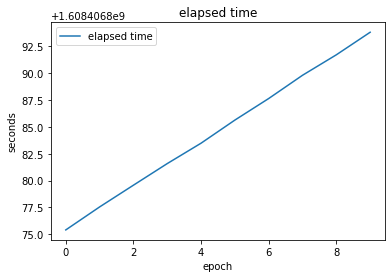

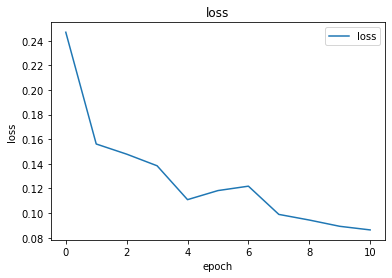

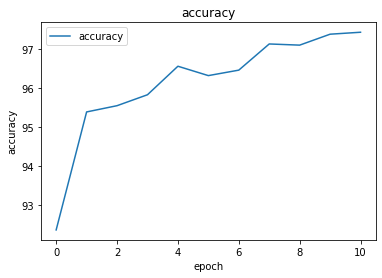

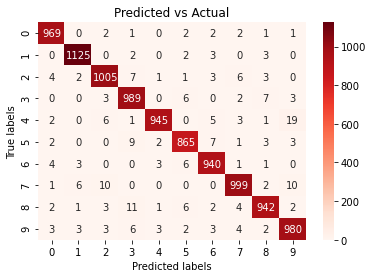

In [11]:
# you change the configuration for the network in the init of Network class
print('\n')
network = Network()
print("Network initialized")
print('\n')

# retrieve data
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print("Data has been loaded")
print("Number of images in dataset: ", len(X_train) + len(X_val))
print("Number of images to test on: ", len(X_test))
print('\n')

# parameters for the network
epochs = 30
minibatch_length = 35

print("Number of epochs: ", epochs)
print("Minibatch length: ", minibatch_length)
print('\n')

print("Epochs have started!")
print('\n')

# initial values for loss for each batch and accuracy
initial_accuracy = network.accuracy(X_val, y_val) / len(X_val) * 100
acc_list_on_epochs = []
inital_loss = network.loss(X_val, y_val)
loss_list_on_epochs = [inital_loss]
print("Inital accuracy: {:.8f}".format(initial_accuracy))
print("Inital loss:     {:.8f}".format(inital_loss))
print('\n')

start = time.time()

# start program here
# for each epoch
total_training_time = []
for epoch in range(epochs):

    print("Current epoch: ", epoch + 1)

    # split data in minibatches
    X_batches, y_batches = network.split_data_in_batches(
        X_train, y_train, minibatch_length=minibatch_length)

    # for each minibatch
    for X_batch, y_batch in zip(X_batches, y_batches):
        network.train(X_batch, y_batch)

    # calculate accuracy and loss after each epoch
    acc_sum = network.accuracy(X_val, y_val)
    acc_list_on_epochs.append(acc_sum / len(X_val) * 100)

    epoch_loss = network.loss(X_val, y_val)
    loss_list_on_epochs.append(epoch_loss)

    # STOPPING CRITERION
    # we decided to have the loss as our stopping criterion
    # our loss can go up or down because the Categorical Cross-Entropy loss (WE DID OURSELVES) and gradient for our loss (WHICH WE COPIED - reference in file)
    # are similar, but not dependent on each other, meaning:
    # we did not use the Categorical Cross-Entropy loss funtion to compute the gradient
    # BUT, it still works, the cost we calculated gets lower with each minibatch so we can compare it with the last minibatch
    # if it doesnt change much, we stop training and print accuracy and loss
    
    if(np.abs(loss_list_on_epochs[-1] - loss_list_on_epochs[-2]) < 0.003):

        print("Accuracy:       {:.2f} / 100 on {} examples".format(acc_list_on_epochs[-1], len(y_val)))
        print("Loss:           {:.8f}".format(loss_list_on_epochs[-1]))
        print('\n')
        print("--- NN has saturated ---")
        break
    # if we havent reached saturation, we print this at the end of the last epoch
    print("Accuracy:       {:.2f} / 100 on {} examples".format(acc_list_on_epochs[-1], len(y_val)))
    print("Loss:           {:.8f}".format(loss_list_on_epochs[-1]))
    print('\n')

    end = time.time()
    total_training_time.append(end)

end = time.time()
print('\n')
print("Time spent for all epochs: ", end-start)
print('\n')

# here we test on X_TEST and Y_TEST
# we return the accuracy on the TEST DATA
print("Testing")
test_acc = network.accuracy(X_test, y_test)
print("Test accuracy: ", test_acc, "/", len(y_test))

# plots

plt.plot(total_training_time)
plt.title("elapsed time")
plt.ylabel('seconds')
plt.xlabel('epoch')
plt.legend(['elapsed time'], loc='best')
plt.show()

plt.plot(loss_list_on_epochs[1:])
plt.title("loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='best')
plt.show()

plt.plot(acc_list_on_epochs)
plt.title("accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy'], loc='best')
plt.show()

# confusion matrix

y_pred = network.forward(X_test)
y_pred = y_pred[-1]
y_pred = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred)

# https://likegeeks.com/seaborn-heatmap-tutorial/
# Like Geeks. 2020. 
# Seaborn heatmap tutorial (Python Data Visualization) - Like Geeks. 
# [ONLINE] Available at: https://likegeeks.com/seaborn-heatmap-tutorial/. 
# [Accessed 17 December 2020].
# used this for plotting the confusion matrix with SEABORN
# we didnt use matplotlib because we didnt know how to place the numbers in the squares with matplotlib
# line 147 - sns.heatmap( ANNOT means annotated squared)

ax = plt.subplot()
ax.set_title('Predicted vs Actual')
ax.xaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
ax.yaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
sns.heatmap(cm, annot=True, ax=ax, cmap='Reds', fmt='g')
plt.xlabel('Predicted labels', axes=ax)
plt.ylabel('True labels', axes=ax)
plt.show()